In [ ]:
from sklearn.tree import DecisionTreeClassifier
from lib.utils import load_raw,load_psd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn.functional import relu,one_hot

In [ ]:
raw = load_raw(2)
df = load_psd(2)

In [ ]:
eeg = raw.get_data(picks='EEG')[0]

In [ ]:
X = eeg.reshape(-1,5000)
y = np.array(pd.Categorical(df['label']).codes)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).reshape(-1,1).long()

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,shuffle=True,stratify=y)

In [134]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.c1 = nn.Conv1d(in_channels=1,out_channels=1,kernel_size=3)
        self.mp1 = nn.MaxPool1d(kernel_size=2)
        self.c2 = nn.Conv1d(in_channels=1,out_channels=1,kernel_size=3)
        self.mp2 = nn.MaxPool1d(kernel_size=2)
        self.c3 = nn.Conv1d(in_channels=1,out_channels=1,kernel_size=3)
        self.mp3 = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.d1 = nn.Linear(623,3)

    def forward(self,x):
        x = self.c1(x)
        x = self.mp1(x)
        x = self.c2(x)
        x = self.mp2(x)
        x = self.c3(x)
        x = self.mp3(x)
        x = self.flatten(x)
        x = self.d1(x)
        return x
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [135]:
input = X_train[0]

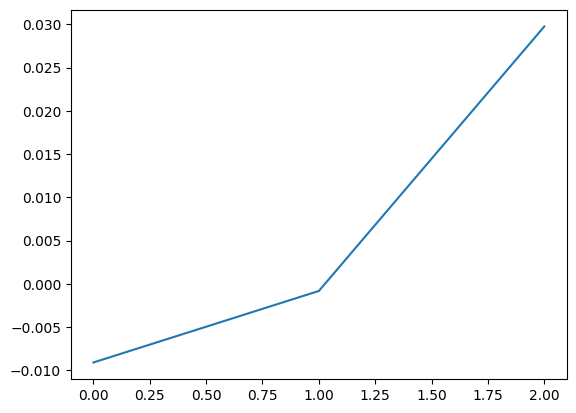

In [136]:
output = model(input.reshape(-1,1,5000))
plt.plot(output.squeeze().detach())

In [137]:
output.shape

torch.Size([1, 3])

In [138]:
y_train_one_hot = one_hot(y_train,num_classes=3).reshape(-1,3).float()
y_test_one_hot = one_hot(y_test,num_classes=3).reshape(-1,3).float()

In [139]:
train_losses= []
test_losses = []

In [140]:
# X_train = X_train.cuda()
# y_train_one_hot = y_train_one_hot.cuda()
# X_test = X_test.cuda()
# y_test_one_hot = y_test_one_hot.cuda()
X_train = X_train.reshape(-1,1,5000)
y_train_one_hot = y_train_one_hot
X_test = X_test
y_test_one_hot = y_test_one_hot

In [147]:
for epoch in range(10):
    logits = model(X_train)
    loss = criterion(logits,y_train_one_hot)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss)
    # train_losses.append(loss.item())
    # test_logits = model(X_test)
    # test_loss = criterion(test_logits,y_test_one_hot)
    # test_losses.append(test_loss.item())

tensor(1.0855, grad_fn=<DivBackward1>)
tensor(1.0789, grad_fn=<DivBackward1>)
tensor(1.0698, grad_fn=<DivBackward1>)
tensor(1.0585, grad_fn=<DivBackward1>)
tensor(1.0450, grad_fn=<DivBackward1>)
tensor(1.0297, grad_fn=<DivBackward1>)
tensor(1.0129, grad_fn=<DivBackward1>)
tensor(0.9951, grad_fn=<DivBackward1>)
tensor(0.9768, grad_fn=<DivBackward1>)
tensor(0.9587, grad_fn=<DivBackward1>)


In [ ]:
plt.plot(train_losses)
plt.plot(test_losses)

In [ ]:
y_pred_logits = model(X_test)
sm = nn.Softmax(dim=1)
y_pred = sm(y_pred_logits).argmax(axis=1)

In [ ]:
y_test = y_test.numpy().squeeze()

In [ ]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred.cpu().numpy(),normalize='true'),display_labels=['P','S','W'])
cm.plot()